<a href="https://colab.research.google.com/github/jyryu3161/bio_system_design/blob/main/Lab1_ML_biopart_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

# One-hot encoding 기반 linear regression 모델

DNA 서열 회귀 분석 시작
=== 데이터 로딩 및 전처리 ===
원본 데이터 크기: (455, 2)
컬럼: ['Seq', 'Label']

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Seq     455 non-null    object 
 1   Label   451 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB
None

기술 통계:
            Label
count  451.000000
mean    30.112024
std     17.748570
min      4.925843
25%     15.471095
50%     27.400074
75%     40.779107
max    105.376998

NaN 값 개수:
Seq      0
Label    4
dtype: int64

NaN 제거 후 데이터 크기: (451, 2)
=== DNA 서열 One-Hot Encoding ===
최대 DNA 서열 길이: 20
One-hot encoding 후 특성 개수: 80

인코딩된 특성 shape: (451, 80)
타겟 shape: (451,)
=== 데이터 분할 (Train 80% / Test 20%) ===
Train 데이터: 360 샘플
Test  데이터: 91 샘플
=== 모델 1: OLS(LinearRegression) ===
[OLS (LinearRegression)]
  Train - Spearman Corr: 0.5228, p-value: 0.000000
  Test  - Spearman Corr: 0.2926, p-value: 0.004886
모델 저

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.14437e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89458e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.88466e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.91681e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[RidgeCV (scaled)]
  Train - Spearman Corr: 0.5267, p-value: 0.000000
  Test  - Spearman Corr: 0.3045, p-value: 0.003339
  -> 선택된 alpha: 109.854114
모델 저장 완료 -> model_ridgecv.joblib
=== Results Visualization (Train/Test, OLS vs Ridge) ===


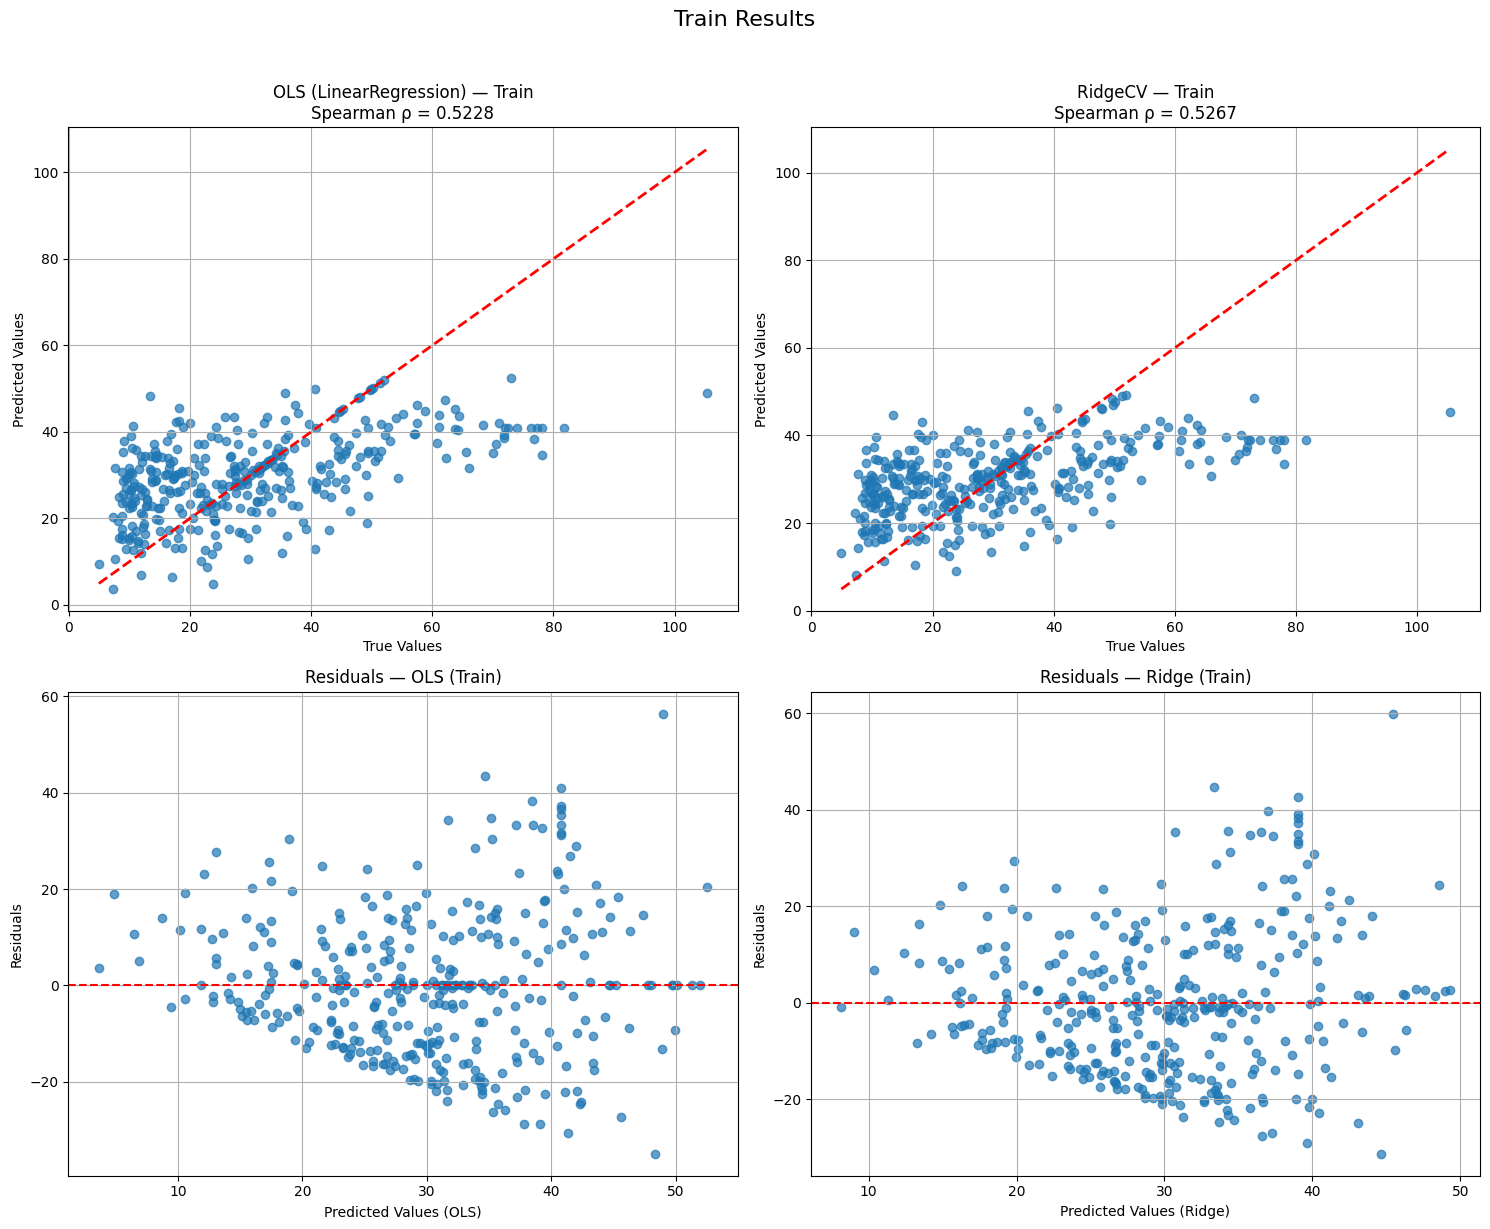

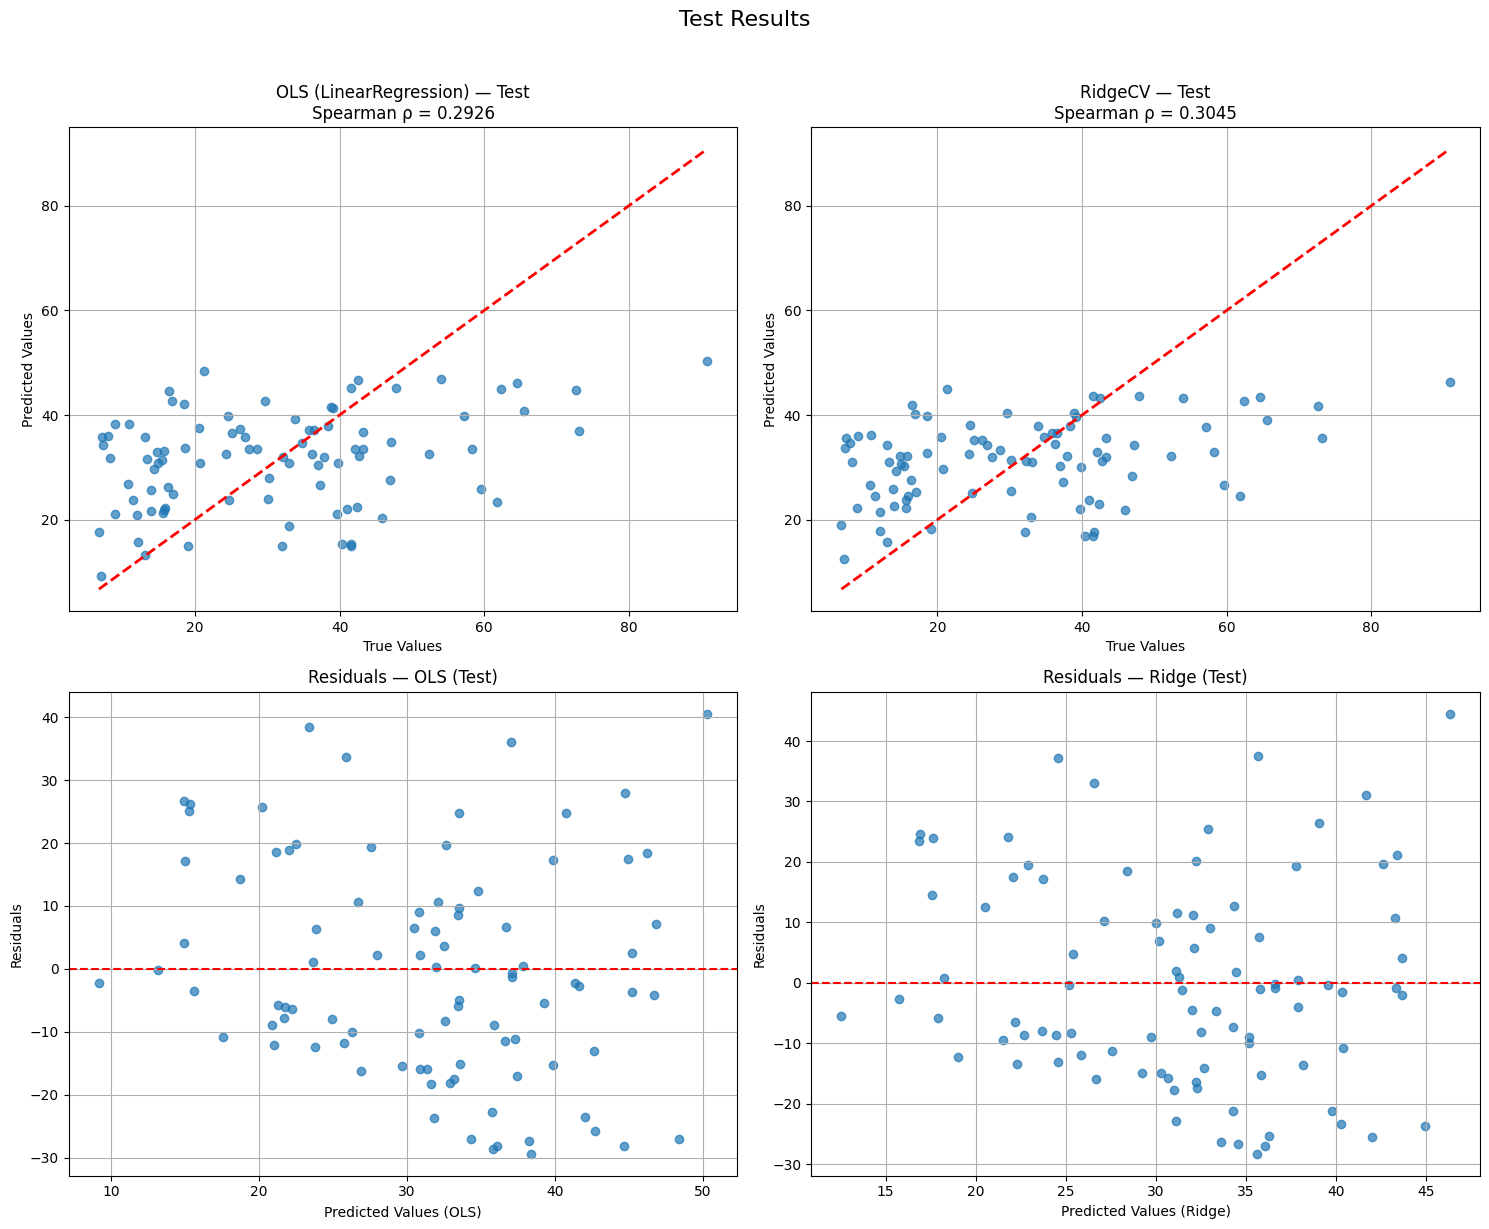

모델 로딩 완료 <- model_ols.joblib
모델 로딩 완료 <- model_ridgecv.joblib
[Reloaded] OLS Test Spearman Corr:   0.2926
[Reloaded] Ridge Test Spearman Corr: 0.3045


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import joblib

# =============================================================================
# 1) 데이터 로딩 및 전처리
# =============================================================================

def load_and_preprocess_data(file_path):
    """
    CSV 파일을 로딩하고 전처리를 수행합니다.
    """
    print("=== 데이터 로딩 및 전처리 ===")
    df = pd.read_csv(file_path)
    print(f"원본 데이터 크기: {df.shape}")
    print(f"컬럼: {df.columns.tolist()}")
    print("\n데이터 정보:")
    print(df.info())
    print("\n기술 통계:")
    print(df.describe())
    print(f"\nNaN 값 개수:")
    print(df.isnull().sum())

    # NaN 값이 있는 행 제거
    df_clean = df.dropna()
    print(f"\nNaN 제거 후 데이터 크기: {df_clean.shape}")
    return df_clean

# =============================================================================
# 2) DNA 서열 One-Hot Encoding (패딩 지원)
# =============================================================================

def dna_to_onehot(sequence):
    """
    DNA 서열을 one-hot encoding으로 변환합니다.
    A, T, G, C -> one-hot, 그 외(N 등)는 [0,0,0,0].
    """
    nucleotide_dict = {'A': [1,0,0,0], 'T': [0,1,0,0], 'G': [0,0,1,0], 'C': [0,0,0,1]}
    encoded = []
    for nucleotide in str(sequence).upper():
        encoded.extend(nucleotide_dict.get(nucleotide, [0,0,0,0]))
    return np.array(encoded, dtype=np.float32)

def encode_sequences(sequences):
    """
    여러 DNA 서열을 one-hot으로 변환.
    길이가 다르면 최장 길이에 맞춰 오른쪽 0-패딩.
    """
    print("=== DNA 서열 One-Hot Encoding ===")
    sequences = sequences.astype(str)
    lengths = sequences.map(len)
    max_len = int(lengths.max())
    print(f"최대 DNA 서열 길이: {max_len}")
    print(f"One-hot encoding 후 특성 개수: {max_len * 4}")

    encoded_sequences = []
    for seq in sequences:
        enc = dna_to_onehot(seq)
        cur_len = len(seq)
        if cur_len < max_len:
            pad_zeros = np.zeros((max_len - cur_len) * 4, dtype=np.float32)
            enc = np.concatenate([enc, pad_zeros], axis=0)
        encoded_sequences.append(enc)

    X = np.vstack(encoded_sequences)  # (n_samples, max_len*4)
    return X

# =============================================================================
# 3) 데이터 분할 (Train/Test = 80/20)
# =============================================================================

def split_data(X, y, test_size=0.2, random_state=42):
    print("=== 데이터 분할 (Train 80% / Test 20%) ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Train 데이터: {X_train.shape[0]} 샘플")
    print(f"Test  데이터: {X_test.shape[0]} 샘플")
    return X_train, X_test, y_train, y_test

# =============================================================================
# 4) 공통: 성능 지표/저장/로딩 (Spearman Correlation 사용)
# =============================================================================

def regression_metrics(y_true, y_pred):
    """
    Spearman correlation과 p-value를 계산합니다.
    """
    corr, p_value = spearmanr(y_true, y_pred)
    return {
        "spearman_corr": float(corr),
        "p_value": float(p_value)
    }

def print_metrics(name, tr, te):
    print(f"[{name}]")
    print(f"  Train - Spearman Corr: {tr['spearman_corr']:.4f}, p-value: {tr['p_value']:.6f}")
    print(f"  Test  - Spearman Corr: {te['spearman_corr']:.4f}, p-value: {te['p_value']:.6f}")

def save_model(model, path):
    joblib.dump(model, path)
    print(f"모델 저장 완료 -> {path}")

def load_model(path):
    model = joblib.load(path)
    print(f"모델 로딩 완료 <- {path}")
    return model

# =============================================================================
# 5) 모델 1: OLS (LinearRegression)
# =============================================================================

def train_eval_ols(X_train, X_test, y_train, y_test, model_path="model_ols.joblib"):
    print("=== 모델 1: OLS(LinearRegression) ===")
    ols = LinearRegression()
    ols.fit(X_train, y_train)

    y_tr_pred = ols.predict(X_train)
    y_te_pred = ols.predict(X_test)

    tr = regression_metrics(y_train, y_tr_pred)
    te = regression_metrics(y_test,  y_te_pred)
    print_metrics("OLS (LinearRegression)", tr, te)

    save_model(ols, model_path)
    return ols, (y_tr_pred, y_te_pred), (tr, te)

# =============================================================================
# 6) 모델 2: RidgeCV (표준화 + 알파 교차검증)
# =============================================================================

def train_eval_ridgecv(X_train, X_test, y_train, y_test, model_path="model_ridgecv.joblib"):
    """
    RidgeCV는 알파(규제 강도)를 내부 CV로 선택합니다.
    스케일 민감하므로 StandardScaler와 Pipeline 구성.
    """
    print("=== 모델 2: RidgeCV (with StandardScaler) ===")
    alphas = np.logspace(-4, 4, 50)  # 넓은 탐색 범위
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", RidgeCV(alphas=alphas, cv=5, store_cv_values=False))
    ])
    ridge_pipe.fit(X_train, y_train)

    y_tr_pred = ridge_pipe.predict(X_train)
    y_te_pred = ridge_pipe.predict(X_test)

    tr = regression_metrics(y_train, y_tr_pred)
    te = regression_metrics(y_test,  y_te_pred)
    print_metrics("RidgeCV (scaled)", tr, te)

    # 선택된 alpha 확인(파이프라인 내부 추출)
    chosen_alpha = ridge_pipe.named_steps["ridge"].alpha_
    print(f"  -> 선택된 alpha: {chosen_alpha:.6f}")

    save_model(ridge_pipe, model_path)
    return ridge_pipe, (y_tr_pred, y_te_pred), (tr, te)

# =============================================================================
# 7) 시각화 (Train/Test 각각 2x2 패널: OLS/Ridge 예측 vs 실제 + 잔차)
# =============================================================================

def plot_results_two_models(y_train, y_test,
                            ols_tr_pred, ols_te_pred,
                            ridge_tr_pred, ridge_te_pred):
    """
    각 split(Train/Test)마다 2x2 패널:
      (1,1) OLS 예측 vs 실제
      (1,2) Ridge 예측 vs 실제
      (2,1) OLS 잔차
      (2,2) Ridge 잔차
    """
    def _one_split_panels(y_true, pred1, pred2, split_name):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        y_min, y_max = float(np.min(y_true)), float(np.max(y_true))

        # Spearman correlation 계산
        spearman_ols, _ = spearmanr(y_true, pred1)
        spearman_ridge, _ = spearmanr(y_true, pred2)

        # (1,1) OLS: 예측 vs 실제
        axes[0, 0].scatter(y_true, pred1, alpha=0.7)
        axes[0, 0].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
        axes[0, 0].set_xlabel('True Values')
        axes[0, 0].set_ylabel('Predicted Values')
        axes[0, 0].set_title(f'OLS (LinearRegression) — {split_name}\nSpearman ρ = {spearman_ols:.4f}')
        axes[0, 0].grid(True)

        # (1,2) Ridge: 예측 vs 실제
        axes[0, 1].scatter(y_true, pred2, alpha=0.7)
        axes[0, 1].plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
        axes[0, 1].set_xlabel('True Values')
        axes[0, 1].set_ylabel('Predicted Values')
        axes[0, 1].set_title(f'RidgeCV — {split_name}\nSpearman ρ = {spearman_ridge:.4f}')
        axes[0, 1].grid(True)

        # (2,1) OLS 잔차
        resid1 = y_true - pred1
        axes[1, 0].scatter(pred1, resid1, alpha=0.7)
        axes[1, 0].axhline(0, linestyle='--', color='r')
        axes[1, 0].set_xlabel('Predicted Values (OLS)')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title(f'Residuals — OLS ({split_name})')
        axes[1, 0].grid(True)

        # (2,2) Ridge 잔차
        resid2 = y_true - pred2
        axes[1, 1].scatter(pred2, resid2, alpha=0.7)
        axes[1, 1].axhline(0, linestyle='--', color='r')
        axes[1, 1].set_xlabel('Predicted Values (Ridge)')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].set_title(f'Residuals — Ridge ({split_name})')
        axes[1, 1].grid(True)

        fig.suptitle(f'{split_name} Results', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

    print("=== Results Visualization (Train/Test, OLS vs Ridge) ===")
    _one_split_panels(y_train, ols_tr_pred, ridge_tr_pred, "Train")
    _one_split_panels(y_test,  ols_te_pred, ridge_te_pred, "Test")

# =============================================================================
# 8) 메인 실행
# =============================================================================

def main():
    """
    전체 파이프라인 실행 (Train 80% / Test 20%)
    - 모델1: OLS(LinearRegression)
    - 모델2: RidgeCV(Scaler 포함, CV로 alpha 선택)
    - 두 모델 모두 저장 & 재로딩 예시 포함
    """
    print("DNA 서열 회귀 분석 시작")
    print("=" * 50)

    # 1) 데이터 로딩
    df = load_and_preprocess_data('data.csv')
    X = encode_sequences(df['Seq'])
    y = df['Label'].values

    print(f"\n인코딩된 특성 shape: {X.shape}")
    print(f"타겟 shape: {y.shape}")

    # 2) 분할 (80/20)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

    # 3) 모델 학습/평가/저장
    ols_path = "model_ols.joblib"
    ridge_path = "model_ridgecv.joblib"

    ols_model, (ols_tr_pred, ols_te_pred), _ = train_eval_ols(
        X_train, X_test, y_train, y_test, model_path=ols_path
    )
    ridge_model, (ridge_tr_pred, ridge_te_pred), _ = train_eval_ridgecv(
        X_train, X_test, y_train, y_test, model_path=ridge_path
    )

    # 4) 시각화
    plot_results_two_models(
        y_train, y_test,
        ols_tr_pred, ols_te_pred,
        ridge_tr_pred, ridge_te_pred
    )

    # 5) 재로딩 예시 (둘 다)
    reloaded_ols = load_model(ols_path)
    reloaded_ridge = load_model(ridge_path)
    ols_te_pred_reload = reloaded_ols.predict(X_test)
    ridge_te_pred_reload = reloaded_ridge.predict(X_test)

    # Spearman correlation으로 재로딩 모델 평가
    ols_spearman_reload, _ = spearmanr(y_test, ols_te_pred_reload)
    ridge_spearman_reload, _ = spearmanr(y_test, ridge_te_pred_reload)
    print(f"[Reloaded] OLS Test Spearman Corr:   {ols_spearman_reload:.4f}")
    print(f"[Reloaded] Ridge Test Spearman Corr: {ridge_spearman_reload:.4f}")

# 실행
if __name__ == "__main__":
    main()

# 서열 생성

=== 랜덤 변이 서열 생성 (최대 3개 변이) ===
원본: TTTAAGAAGGAGATATACAT
생성된 변이 서열: 5000개

=== 상위 5개 서열 ===
1. TTTAAGAGGGAGATAAACAA (예측값: 68.5880)
2. CTTAAGAGGGAGATATACAA (예측값: 67.9259)
3. CCGAAGAAGGAGATATACAT (예측값: 65.1485)
4. CTTAAGAAGGAGATAAACAT (예측값: 62.5515)
5. CTTAAGAAGGAGATAAACAT (예측값: 62.5515)

=== 하위 5개 서열 ===
1. TTTAAACAGGAGAAATACAT (예측값: -10.0651)
2. GGTAAGAAGGAGAAATACAT (예측값: -8.8250)
3. TTTAAGTAGCAGAAATACAT (예측값: -7.8635)
4. TTTAAGAAGGAGAAATACAG (예측값: -5.8596)
5. TTTAAGAAGGAGAAACTCAT (예측값: -4.8789)


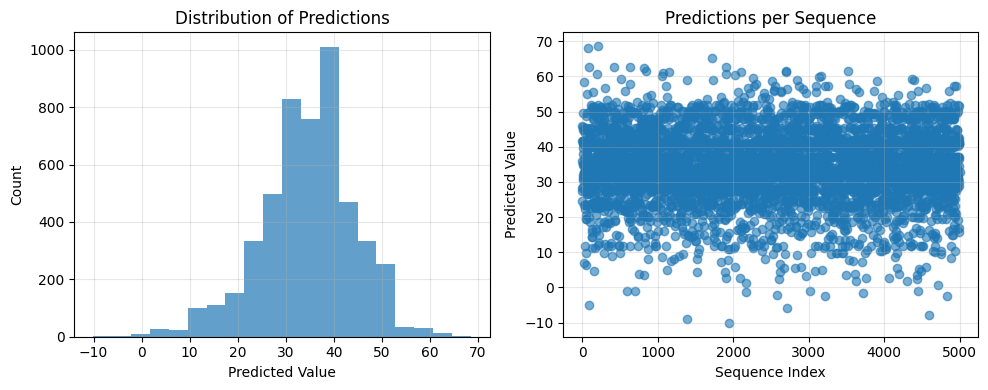

In [12]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# 1) 간단한 one-hot 인코더
def dna_to_onehot(seq):
    code = {'A':[1,0,0,0], 'T':[0,1,0,0], 'G':[0,0,1,0], 'C':[0,0,0,1]}
    out = []
    for nt in seq.upper():
        out.extend(code.get(nt, [0,0,0,0]))
    return np.array(out, dtype=np.float32)

def encode_sequences(seq_list):
    return np.vstack([dna_to_onehot(s) for s in seq_list])

# 2) 랜덤 변이 생성기
def generate_random_variants(seed, n, max_mutations=5, rng_seed=42):
    """
    - 각 서열마다 1~max_mutations 개의 랜덤 변이 생성
    - 위치와 염기 모두 랜덤 선택
    """
    rng = np.random.default_rng(rng_seed)
    seed = seed.upper()
    L = len(seed)
    bases = ['A', 'T', 'G', 'C']

    variants = []
    for _ in range(n):
        seq_list = list(seed)

        # 랜덤하게 변이 개수 선택 (1~max_mutations)
        num_muts = rng.integers(1, max_mutations + 1)

        # 랜덤 위치 선택
        positions = rng.choice(L, size=num_muts, replace=False)

        # 각 위치를 랜덤 염기로 변경
        for pos in positions:
            seq_list[pos] = rng.choice(bases)

        variants.append("".join(seq_list))

    return variants

# 3) 예측 및 분석
def predict_variants(seed="TTTAAGAAGGAGATATACAT",
                    n=100,
                    max_mutations=3,
                    model_path="model_ols.joblib"):

    print(f"=== 랜덤 변이 서열 생성 (최대 {max_mutations}개 변이) ===")
    variants = generate_random_variants(seed, n, max_mutations)
    print(f"원본: {seed}")
    print(f"생성된 변이 서열: {len(variants)}개")

    # 데이터프레임 생성
    df = pd.DataFrame({"Seq": variants})

    # One-hot 인코딩
    X = encode_sequences(df["Seq"])

    # 모델 로딩 및 예측
    model = joblib.load(model_path)
    predictions = model.predict(X)
    df["Prediction"] = predictions

    # 결과 정렬
    df_sorted = df.sort_values("Prediction", ascending=False).reset_index(drop=True)

    # 상위/하위 결과 출력
    print("\n=== 상위 5개 서열 ===")
    for i in range(5):
        seq = df_sorted.iloc[i]["Seq"]
        pred = df_sorted.iloc[i]["Prediction"]
        print(f"{i+1}. {seq} (예측값: {pred:.4f})")

    print("\n=== 하위 5개 서열 ===")
    for i in range(5):
        seq = df_sorted.iloc[-(i+1)]["Seq"]
        pred = df_sorted.iloc[-(i+1)]["Prediction"]
        print(f"{i+1}. {seq} (예측값: {pred:.4f})")

    # 간단한 시각화
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(df["Prediction"], bins=20, alpha=0.7)
    plt.xlabel("Predicted Value")
    plt.ylabel("Count")
    plt.title("Distribution of Predictions")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(range(len(df)), df["Prediction"], alpha=0.6)
    plt.xlabel("Sequence Index")
    plt.ylabel("Predicted Value")
    plt.title("Predictions per Sequence")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_sorted

# 4) 실행
if __name__ == "__main__":
    result = predict_variants(
        seed="TTTAAGAAGGAGATATACAT",
        n=5000,
        max_mutations=3,
        model_path="model_ols.joblib"
    )

# Genetic algorithm 기반 서열 생성

In [6]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 1.7 MB/s eta 0:00:00


- 개체 표현: 길이 L의 정수배열(각 유전자 0/1/2/3 → A/T/G/C)
- 적합도: 저장된 model_ols.joblib(OLS 선형회귀)로 one-hot 임베딩 후 - 예측값을 그대로 최대화
- 초기 개체군은 랜덤 + (선택) 시드 서열 주입

[OK] 모델 로딩: model_ols.joblib
[Gen 001] Best fitness = 48.8508
[Gen 002] Best fitness = 54.3055
[Gen 003] Best fitness = 68.8537
[Gen 004] Best fitness = 77.4827
[Gen 005] Best fitness = 77.4827
[Gen 010] Best fitness = 100.1591
[Gen 020] Best fitness = 102.2937
[Gen 030] Best fitness = 107.6403
[Gen 040] Best fitness = 107.6403
[Gen 050] Best fitness = 109.9461
[Gen 060] Best fitness = 112.7090
[Gen 070] Best fitness = 112.7090
[Gen 080] Best fitness = 112.7090
[Gen 090] Best fitness = 112.7090
[Gen 100] Best fitness = 112.7090

==================== 결과 ====================
Best sequence : CCTGCGAGGGGGGTAACCAA
Predicted val : 112.709015
Seed          : TTTAAGAAGGAGATATACAT


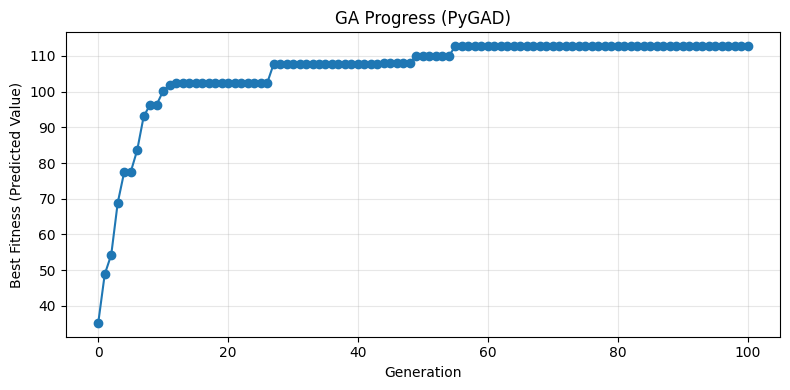


Top-k in final population:
                    Seq  Prediction
0  CCTGCGAGGGGGGTAACCAA  112.709015
1  CCGGCGAGGGAGGTAAACAA  111.661591
2  CCGGCGAGGGGGTTAACAAA  109.613434
3  CCGACGAGGGGGATAAACAA  101.712753
4  CCGTCGAGGGGGTTGACCAA   99.664215
5  CCGGCGAGGGAGATGAACAA   98.255249
6  CCGGCGAGGGAGGGAACTAA   98.106636
7  CCTTCGAGGGGGGTGACCAA   97.474152
8  CCTGCGAGGGGGATAAGCAA   96.590080
9  CCCGCGAGTGGGGTAAACGA   96.313606


In [13]:
# ==========================================
# PyGAD로 GA 수행하여 서열 최적화 (튜토리얼 버전)
# 목표: 저장된 model_ols.joblib의 예측값을 최대화하는 DNA 서열 찾기
# ==========================================
import numpy as np
import pandas as pd
import joblib
import pygad
import matplotlib.pyplot as plt

# ---------- 0) 모델 로딩 ----------
MODEL_PATH = "model_ols.joblib"   # 미리 학습/저장된 OLS 모델
model = joblib.load(MODEL_PATH)
print(f"[OK] 모델 로딩: {MODEL_PATH}")

# ---------- 1) 간단 유틸: A/T/G/C <-> 0/1/2/3 ----------
IDX2BASE = np.array(list("ATGC"))
BASE2IDX = {b:i for i,b in enumerate("ATGC")}

def ints_to_seq(int_array):
    """정수 배열(0/1/2/3)을 DNA 문자열로 변환."""
    return "".join(IDX2BASE[int_array])

def seq_to_ints(seq):
    """DNA 문자열을 정수 배열로 변환(A/T/G/C만 가정)."""
    return np.array([BASE2IDX.get(ch, 0) for ch in seq.upper()], dtype=np.int64)

# ---------- 2) one-hot 인코딩 ----------
def dna_to_onehot(seq):
    """A,T,G,C -> 4차원 one-hot (기타 문자는 [0,0,0,0])."""
    code = {'A':[1,0,0,0], 'T':[0,1,0,0], 'G':[0,0,1,0], 'C':[0,0,0,1]}
    out = []
    for nt in seq.upper():
        out.extend(code.get(nt, [0,0,0,0]))
    return np.array(out, dtype=np.float32)

# ---------- 3) 문제 설정 ----------
seed_seq = "TTTAAGAAGGAGATATACAT"  # 길이 L=20
L = len(seed_seq)

# PyGAD에서 유전자의 값 범위를 지정 (정수 0/1/2/3 = A/T/G/C)
gene_space = [0, 1, 2, 3]

# ---------- 4) Fitness 함수 (v2.20.0 시그니처: 3개 인자) ----------
def fitness_func(ga_instance, solution, solution_idx):
    """
    1) ga_instance: GA 인스턴스 (필수 형식)
    2) solution: 길이 L의 정수 배열 (각 유전자 0/1/2/3)
    3) solution_idx: 인덱스
    """
    seq = ints_to_seq(solution.astype(int))      # 정수배열 -> DNA 문자열
    X = dna_to_onehot(seq).reshape(1, -1)        # one-hot (1, L*4)
    pred = model.predict(X)[0]                   # 클수록 좋은 점수
    return float(pred)

# ---------- 5) 세대별 로그(선택) ----------
def on_generation(ga_instance):
    best_fitness = ga_instance.best_solution()[1]
    gen = ga_instance.generations_completed
    if gen % 10 == 0 or gen <= 5:
        print(f"[Gen {gen:03d}] Best fitness = {best_fitness:.4f}")

# ---------- 6) GA 인스턴스 생성 ----------
ga = pygad.GA(
    num_generations=100,           # 세대 수
    num_parents_mating=20,         # 교배에 참여할 부모 수
    fitness_func=fitness_func,     # (중요) 3개 인자 받는 함수
    sol_per_pop=60,                # 개체군 크기
    num_genes=L,                   # 유전자 수 = 서열 길이
    gene_space=gene_space,         # 각 유전자 값 범위
    gene_type=int,                 # 정수 유전자 (중요!)
    parent_selection_type="sss",   # 단순 steady-state selection
    crossover_type="single_point", # 단일 포인트 교차
    mutation_type="random",        # 무작위 변이
    mutation_percent_genes=10,     # 변이 비율(%)
    keep_elitism=2,                # 엘리트 보존
    on_generation=on_generation,
    random_seed=42
)

# ---------- 7) 초기 개체군에 seed 주입 (튜토리얼용) ----------
rng = np.random.default_rng(42)
init_pop = []

# 1) seed 그대로
init_pop.append(seq_to_ints(seed_seq))

# 2) seed에서 한 자리만 바꾼 변형 9개
for _ in range(9):
    arr = seq_to_ints(seed_seq)
    pos = rng.integers(0, L)
    choices = [0,1,2,3]
    choices.remove(arr[pos])   # 원래 염기 제외
    arr[pos] = rng.choice(choices)
    init_pop.append(arr)

# 3) 나머지는 랜덤
while len(init_pop) < ga.sol_per_pop:
    init_pop.append(rng.integers(0, 4, size=L, dtype=np.int64))

ga.initial_population = np.array(init_pop, dtype=np.int64)

# ---------- 8) 실행 ----------
ga.run()

# ---------- 9) 결과 ----------
solution, fitness, solution_idx = ga.best_solution()
best_seq = ints_to_seq(solution.astype(int))
best_pred = fitness  # fitness_func이 예측값을 반환하므로 동일

print("\n==================== 결과 ====================")
print(f"Best sequence : {best_seq}")
print(f"Predicted val : {best_pred:.6f}")
print(f"Seed          : {seed_seq}")
print("==============================================")

# ---------- 10) 피트니스 추이 시각화 ----------
plt.figure(figsize=(8,4))
plt.plot(ga.best_solutions_fitness, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Predicted Value)")
plt.title("GA Progress (PyGAD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 11) 상위 k개 보기 (마지막 세대 개체군 기준, 선택) ----------
k = 10
pop = ga.population
# v2.20.0 시그니처에 맞춰 적합도 계산
scores = np.array([fitness_func(ga, ind, i) for i, ind in enumerate(pop)])
idx = np.argsort(scores)[::-1][:k]
top_df = pd.DataFrame({
    "Seq": ["".join(IDX2BASE[pop[i]]) for i in idx],
    "Prediction": scores[idx]
})
print("\nTop-k in final population:")
print(top_df.reset_index(drop=True))
